<h2>Ranking and Doc2Vec Analysis</h2>

<hr>

<h3> Load Data </h3>

In [4]:
from ranking import Ranking
import numpy as np
import pandas as pd
from doc2vec_embedding import Embedding_doc2vec
import matplotlib.pyplot as plt

Firstly, we load our dataset and initialize the `Ranking` and `Embedding_doc2vec` classes.

In [5]:
df = pd.read_csv('Data/processed_data_v5.csv', sep=';')

ranking = Ranking('texts')

#m = Embedding_doc2vec(path='doc2vecmodel_stopwords.mod')
#df_doc2vec = m.get_dataframe(df)
print(df.columns)

Index(['paper_id', 'title', 'abstract', 'text', 'date', 'authors', 'url',
       'after_dec', 'tag_disease_covid', 'tag_disease_sars',
       'tag_disease_mers', 'tag_disease_corona',
       'tag_design_generic_case_control', 'tag_design_retrospective_cohort',
       'tag_design_cross_sectional_case_control',
       'tag_design_matched_case_control', 'tag_design_prevalence_survey',
       'tag_design_time_series_analysis', 'tag_design_systematic_review',
       'tag_design_randomized_control', 'tag_design_pseudo_randomized_control',
       'tag_design_case_study', 'tag_design_simulation'],
      dtype='object')


The input to our algorithm will we a string such as:

In [6]:
med_dict  = pd.read_excel('Kaggle COVID-19 medical dictionary.xlsx', sheet_name=1)
tasks  = med_dict["Unnamed: 0"].unique()
questions  = med_dict.Question.unique()
subquestions = med_dict.Subquestion.unique()

In [65]:
#query = 'Tools and studies to monitor phenotypic change and potential adaptation of the virus'
query = subquestions[19]

In [8]:
for i, question in enumerate(subquestions):
    print(i, question)

0 Range of incubation periods for humans: general population
1 Range of incubation periods for humans: by age group
2 Range of incubation periods for humans: by health status
3 How long are individuals contagious, even after recovery?
4 Prevalence of asymptomatic shedding: general population
5 Prevalence of asymptomatic shedding: by age
6 Prevalence of asymptomatic shedding: among health cadres
7 Prevalence of asymptomatic shedding: in children
8 Prevalence of asymptomatic shedding: among hospitalized patients with non-COVID dx's
9 Prevalence of asymptomatic shedding: among outpatients 
10 Geographic variation in transmission by temperature and/or humidity
11 Experimental variation in laboratory COVID-19 sample survival at different temperature/humidity conditions
12 Time series analysis of COVID-19 w/data on change over time in temperature and/or humidity
13 Coronovirus charge distribution
14 Coronovirus adhesion to hydrophilic/phobic surfaces
15 Coronovirus susceptibility to environm

<h3> Ranking Scoring Function </h3>

Once we have the query (short query) we obtain a dictionary with paper_id -> similarity.

In [66]:
scores = ranking.get_bm25_scores(query, df[(df.after_dec == True) & (df.tag_disease_covid == True)].paper_id)
#similar = ranking.most_similar(query, df, func='bm25', data='text')
sorted_paper_id = sorted(scores.items(), key=lambda x:x[1], reverse=True)

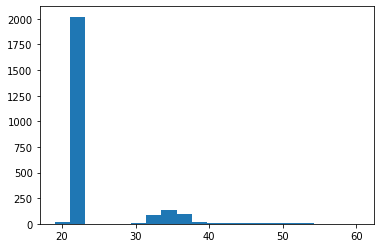

In [67]:
# Plot the score distribution of the raking function
points = sorted(scores.values(), reverse=True)
plt.hist(points, bins=20)
plt.show()

In [68]:
ranking_nearest = [a for a,b in sorted_paper_id] # Ranking function nearest

<h2> Information Retrieval </h2>

Once we have the relevant documents, we must extract the information relevant to the query.

In [69]:
from information_retrieval import *

In [70]:
inforet = Embedding_retrieval()

In [71]:
#ranking_nearest.index('isbq1fqt')
ranking_nearest[:10]

['mfiaubqb',
 'hj8qanbb',
 'q4i9kh65',
 'ro66qxwx',
 'isbq1fqt',
 'd9v5xtx7',
 '8avkjc84',
 'j72tsof8',
 '1awl4val',
 'atnxkvy6']

In [72]:
#print(df[df.paper_id == ranking_nearest[0]].text.values[0])

If we don't use the clusters we obtain the following output:

In [73]:
# NO CLUSTERS
doc_info = []
for paper_id in ranking_nearest:
    actual_doc = []
    row = df.loc[df.paper_id == paper_id]
    if not len(row.text.values) != 0 or not row['after_dec'].values[0]:
        continue
    text = df.loc[df.paper_id == paper_id].text.values[0]
    similar_sent = inforet.get_closest_sentence(query, paper_id, text, topk=10)
    for sent, sim in similar_sent:
        actual_doc.append((paper_id, sent, sim))
    doc_info.append(actual_doc)
    

C:\Users\apunt\tfg\clone_test\covid19_challenge\information_retrieval.py:54: RuntimeWarning: invalid value encountered in log
  idf = np.log((self.num_documents - df + 0.5) / (df + 0.5))


Here we see the most similar senteces to the query from different documents.

In [74]:
print(len(ranking_nearest))

2438


In [75]:
import itertools
all_sent = list(itertools.chain.from_iterable(doc_info))
all_sent = sorted(all_sent, key=lambda x:x[2], reverse=True)

In [76]:
print('For the query: {}'.format(query))
for paper_id, sentence, similarity in all_sent[:5]:
    print(str(similarity) + '  [{}]'.format(paper_id))
    print(sentence)
    print('\n')

For the query: Persistence and stability in fecal matter
0.8107081802561691  [j7t9nebs]
The strong intestinal ACE2 expression is particularly interesting given the emerging clinical reports of fecal shedding and persistence post-recovery which may reflect a fecal-oral transmission pattern 10-12 .


0.7954511192692587  [r5a46n9a]
Second, the viability of virus in stools, plasma and urine, and its role in pathogenesis or transmission need to be clarified.


0.790664655912122  [nil1vv6h]
Differences between sediment and water are not unexpected as the sediment likely represents a longer-term accumulation of biomaterial and the water represents more acute contamination at the surface and variable mixing throughout.


0.7883679097088827  [ztcyvsoi]
The virus is also present in the stool and contamination of the water supply and subsequent transmission via aerosolization/feco oral route is also hypothesized [6].


0.7874811536881253  [wlat2rrl]
Another issue of potential significance, is the

To see the most relevant sentences of the most relevant documents.

In [77]:
for i, doc in enumerate(doc_info):
    if i > 5:
        break
    print('DOCUMENT {}: {}'.format(i+1, doc[0][0]))
    print('-------------------------')
    print('\n')
    for j, item in enumerate(doc[:3]):
        _, sent, similarity = item
        print('Sentence {}: {}'.format(j+1, similarity))
        print(sent)
        print('\n')

DOCUMENT 1: mfiaubqb
-------------------------


Sentence 1: 0.7152209425608703
Virus stability in community or hospital environment may vary and determines a high or low risk of transmission depending upon the significant exposure of the host.


Sentence 2: 0.6902238141857894
It is important to know the natural history of the disease as well as viral shedding in different stages of clinical illness.


Sentence 3: 0.6875128948382141
We should review the available scientific information to identify animal host(s) for preventing continued spill-over and better understanding of various aspects related to SARS CoV2 transmission such as time duration, severity of disease and host susceptibility.


DOCUMENT 2: hj8qanbb
-------------------------


Sentence 1: 0.7839291893084233
Viruses have a direct connection to wastewater and drinking water purification when
they are excreted in feces or urine (Table 1),9 but there is limited data on the
concentration of enveloped viruses in feces and urine

<h3> Doc2Vec Embeddings </h3>

We take the most relevant document to look for the nearest document embeddings.

In [43]:
paper_id = sorted_paper_id[0][0]
text_query = df[df.paper_id==paper_id].text.values[0]

nearest = m.get_nearest(df, paper_id, k=100) # Get nearest from the train vectors
most_similar = m.most_similar(df, 100, text_query) # Infer vector from query and get nearest

We can now check how many of the papers ids are shared between the different nearest approximations.

In [9]:
doc2vec_nearest_set = set(nearest)
ranking_nearest_set = set(ranking_nearest)
doc2vec_most_similar_set = set(most_similar)

length = len(ranking_nearest)

if length != len(ranking_nearest_set) or length != len(doc2vec_most_similar_set):
    print('The sets are not of equal length!')
else:
    print('From a total length of {}'.format(len(doc2vec_nearest_set)))

print('Intersection between nearest and ranking:\
 {}'.format(len(doc2vec_nearest_set.intersection(ranking_nearest_set))))
print('Intersection between most similar and ranking:\
 {}'.format(len(doc2vec_most_similar_set.intersection(ranking_nearest_set))))
print('Intersection between nearest and similar:\
 {}'.format(len(doc2vec_nearest_set.intersection(doc2vec_most_similar_set))))

The sets are not of equal length!
Intersection between nearest and ranking: 39
Intersection between most similar and ranking: 11
Intersection between nearest and similar: 1


<h3> Clustering </h3>

We will compute a k-means clustering with the Doc2Vec embeddings.

In [10]:
clusters  = m.get_clusters(df)

In [11]:
def get_cluster_dict(df, clusters, vector, model_class):
    comm_cluster = model_class.common_cluster(df, clusters, vector = vector)
    d = {}
    for el in comm_cluster:
        key = model_class.get_cluster_for_text(df, clusters, el[0])
        d[key] = el
    return d

For the nearest documents computed before, we can see the distribution over the different clusters.

In [12]:
d_ranking = m.get_cluster_dict(df, clusters, ranking_nearest)
d_nearest = m.get_cluster_dict(df, clusters, nearest)
d_similar = m.get_cluster_dict(df, clusters, most_similar)

print('Ranking:')
print([(key, len(value)) for key, value in d_ranking.items()])
print('Nearest:')
print([(key, len(value)) for key, value in d_nearest.items()])
print('Simmilar:')
print([(key, len(value)) for key, value in d_similar.items()])

Ranking:
[(0, 140), (1, 45), (2, 49), (3, 54), (4, 1306), (5, 34), (6, 36), (7, 108), (8, 18), (9, 5), (10, 55), (11, 17), (12, 37), (13, 25), (14, 17), (15, 19), (16, 17), (17, 11), (18, 36), (19, 62)]
Nearest:
[(0, 4), (1, 5), (2, 2), (4, 80), (7, 2), (19, 2)]
Simmilar:
[(0, 6), (4, 48), (7, 6), (19, 39)]


To understand the different clusters we will look for the most common words in each cluster. This will give us an overview of the cluster thopics.

In [13]:
cluster_papers = []
for i in range(20):
    cluster_papers.append(m.get_one_cluster(df, clusters, i))
    
cluster_length = []
for clus, l in enumerate(cluster_papers):
    cluster_length.append(len(l))
    print(clus, len(l)) # Print cluster number, number of documents

0 2792
1 1546
2 2097
3 2217
4 6614
5 1174
6 1006
7 2163
8 527
9 336
10 1825
11 572
12 1585
13 701
14 333
15 475
16 437
17 475
18 1112
19 1198


In [69]:
from collections import Counter
import re

def get_texts(df, paper_ids):
    # TODO maybe with lemmatization and stemming we will get a better representation
    all_texts = []
    for key in paper_ids:
        t = df.loc[df.paper_id==key].text.values[0]
        list_t = m.filtered_query(t.lower())        
        all_texts += list_t
    return all_texts

We will firt look at one cluster.

In [70]:
cluster_0 = get_texts(df, cluster_papers[0])
word_count_cluster_0 = Counter(cluster_0)
word_count_cluster_0.most_common(10)

[('virus', 9042),
 ('viral', 8930),
 ('protein', 8499),
 ('cells', 8421),
 ('proteins', 8191),
 ('rna', 7503),
 ('viruses', 6328),
 ('cell', 5661),
 ('replication', 4418),
 ('infection', 4089)]

To look at the word distribution over all the clusters run the following cells.

In [ ]:
comm = []
for el in cluster_papers:
    cluster_texts = get_texts(df, el)
    word_count = Counter(cluster_texts)
    comm.append([a for a,b in word_count.most_common(40)])      

In [ ]:
for cl, el in enumerate(comm):
    print('Cluster {}: {}'.format(cl,el[:20]))

Trying train embeddings on the smaller subset.

In [42]:
df.loc[df.paper_id == 'o56j4qio'].title.values[0]

'Prevalence of comorbidities in the novel Wuhan coronavirus (COVID-19) infection: a systematic review and meta-analysis'

The following cell is to select only those documents post COVID19 (01-12-2019)

In [158]:
def check_words(l, abstract):
    for word in l:
        if word in abstract:
            return True
    return False

In [159]:
retr_cluster_7 = []
clus_num = []
count = 0
for paper_id in ranking_nearest:
    if not len(df.loc[df.paper_id == paper_id].text.values) != 0:
        continue
    text = df.loc[df.paper_id == paper_id].text.values[0]
    if not check_words(covid_19, text.lower()):
        continue
    retr_cluster_7.append(inforet.get_closest_sentence(query, paper_id, text, topk=10))
    clus_num.append(m.get_cluster_for_text(df, clusters, paper_id))

In [160]:
for i, doc in enumerate(retr_cluster_7):
    if i > 5:
        break
    print('DOCUMENT {}'.format(i+1))
    print('-------------------------')
    print('\n')
    for j, sent in enumerate(doc):
        if j ==3:
            break
        print('Sentence {}:'.format(j+1))
        print(sent)
        print('\n')

DOCUMENT 1
-------------------------


Sentence 1:
('Incubation period distribution\nUsing the duration of stay in Wuhan and the symptom onset date, we obtained a range of possible values for the incubation period of each case.', 0.7500401634573534)


Sentence 2:
('Comparison of 2019 novel coronavirus, severe acute respiratory syndrome and Middle East respiratory syndrome coronaviruses’ incubation periods\nA comparison to the estimated incubation period distribution for MERS (Table 3 and Figure 3) shows that the incubation period values are remarkably similar, with mean values differing at most 1 day and 95th percentiles differing at most 2 days.', 0.707227909139887)


Sentence 3:
('Our estimate of the mean incubation period is longer than the value of 5.2 days based on 10 cases [12], and 4.8 days (range: 2–11) based on 16 travellers between Wuhan and Guangdong [13].', 0.6975478799169432)


DOCUMENT 2
-------------------------


Sentence 1:
('Incubation period distribution\nUsing the d

In [161]:
count = 0
print('Length ranking_nearest: {}'.format(len(ranking_nearest)))

for paper_id in ranking_nearest:
    if not len(df.loc[df.paper_id == paper_id].text.values) != 0:
        continue
    text = df.loc[df.paper_id == paper_id].text.values[0]
    if check_words(covid_19, text.lower()):
        count+=1

Length ranking_nearest: 2091


In [162]:
print(count)

1316


In [163]:
count_dict = {}
for i in range(20):
    count_dict[i] = 0

for paper_id in df.paper_id:
    if not paper_id in ranking_nearest:
        continue
    if not len(df.loc[df.paper_id == paper_id].text.values) != 0:
        continue
    text = df.loc[df.paper_id == paper_id].text.values[0]
    if check_words(covid_19, text.lower()):
        cluster = m.get_cluster_for_text(df, clusters, paper_id)
        count_dict[cluster] += 1

In [164]:
print(count_dict)

{0: 2, 1: 1, 2: 0, 3: 0, 4: 6, 5: 7, 6: 5, 7: 4, 8: 20, 9: 81, 10: 1091, 11: 11, 12: 0, 13: 9, 14: 17, 15: 1, 16: 3, 17: 8, 18: 50, 19: 0}


In [165]:
for paper_id in cluster_id[13]:
    if paper_id in res.paper_id:
        print(paper_id)
        break

NameError: name 'cluster_id' is not defined

In [ ]:
scores = ranking.get_bm25_scores(query)
similar = ranking.most_similar(query, df, func='bm25', data='text')

In [ ]:
l = []
for i in range(3):
    l.append(inforet.get_closest_sentence(query, list(scores.items())[0][0], similar[i], topk=15))

for i, doc in enumerate(l):
    print('DOCUMENT {}'.format(i+1))
    print('-------------------------')
    print('\n')
    for j, sent in enumerate(doc[:3]):
        print('Sentence {}:'.format(j+1))
        print(sent)
        print('\n')

In [3]:
df[df.after_dec].tag_disease_covid.sum()

2442

To further process the data, we will create two new columns:
- `after_dec`: whether the document is post 01-12-2019. (`bool`)
- `covid19`: whether the document is about COVID19. (`bool`)

In [3]:
import datetime
from datetime import datetime

data = '2020-01-01'
data = datetime.strptime(data, '%Y-%m-%d').date()

covid_19 = ['covid', '2019 ncov', 'sars cov 2', 'sars-cov-2', r'coronavirus 2\b', 
                'coronavirus 2019', 'wuhan coronavirus', 'coronavirus disease 19', 
                'ncov 2019', 'wuhan pneumonia', '2019ncov', 'wuhan virus', 
                r'2019n cov\b', r'2019 n cov\b', 'r\bn cov 2019', 'wuhan']
sars = [r'\bsars\b', 'severe acute respiratory syndrome']
mers = [r'\bmers\b', 'middle east respiratory syndrome']
diverse_corona = ['corona', r'\bcov\b']
print(df['date'])

0        1973-08-31
1        1985-06-28
2        1988-10-14
3        1988-09-16
4        1992-06-22
            ...    
29180    2015-06-30
29181    2018-07-31
29182    2016-10-31
29183    2018-01-31
29184    2013-12-31
Name: date, Length: 29185, dtype: object


In [4]:
def check_date(data, date):
    if len(date.split('-')) < 3:
        date += "-01-01"
    date = datetime.strptime(date, '%Y-%m-%d').date()
    return date > data

def check_covid(l, text):
    trans = str.maketrans('-',' ')
    for word in l:
        if word in text.translate(trans):
            return True
    return False

df['after_dec'] = df.apply(lambda row: check_date(data, row['date']), axis = 1)
df['covid19'] = df.apply(lambda row: check_covid(covid_19, row['text']), axis = 1)

print(df.after_dec.value_counts())
print(df.covid19.value_counts())

False    27094
True      2091
Name: after_dec, dtype: int64
False    29108
True        77
Name: covid19, dtype: int64


In [5]:
r = []
for _, row in df.iterrows():
    if row['after_dec'] and not row['covid19']:
        r.append(row)

In [6]:
type(list(df.columns))

list